# A TOOLKIT FOR EVALUATING LANGUAGE‑MODEL EMBEDDING SPACES

## Overview  
Given that simpler multilingual models remain competitive for classification, how do we pick the best pretrained model?

This notebook implements a novel toolkit for evaluating sentence embeddings across multiple language pairs.

## Contents  
1. **Module Installation and Import**  
   Install required libraries and import all modules.  
2. **Data Wrangling, Labeling and EDA**  
   Load raw data, clean and label it, then perform exploratory data analysis.  
3. **Data Import**  
   Read in prepared datasets for training and evaluation.  
4. **Model Initialization**  
   Instantiate a suite of SentenceTransformer models (monolingual and multilingual).  
5. **Utility Functions for Embedding Generation**  
   Define helper functions for batch encoding, normalization and caching.  
6. **The Toolkit**  
   - **Level 1**: Basic encode-and-search  
   - **Level 2**: Similarity thresholding  
   - **Level 3**: Hierarchical clustering  
   - **Level 4**: Metadata-aware retrieval  
7. **Render Output**  
   Format and visualize embedding results (tables, charts, etc.).  
8. **Testing Models**  
   Evaluate embedding quality on bilingual test sets:  
   - English–Chinese  
   - English–Spanish  
   - English–French  

## Dependencies  
- Python 3.7+  
- All the packages mentioned in the package import

## Usage  
1. Run each cell in order, from top to bottom.  
2. Adjust paths or parameters as needed for your environment.  
3. Refer to section headers for quick navigation.  


# X. Module install and Import

In [ ]:
%pip install ipysheet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output
import pickle
from IPython.display import display, clear_output, Javascript
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import top_k_accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, pearsonr
from tabulate import tabulate
from IPython.display import Markdown
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import top_k_accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
from __future__ import annotations
from typing import Dict, List
import umap.umap_ as umap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import re
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from transformers import AutoConfig
from collections import OrderedDict
import warnings
import shutil
import re
from difflib import SequenceMatcher



# Using the below variable to set random seed
myStudentNumber = 230164781


In [ ]:
"""
mounting Google Drive to access the dataset
"""

drive.mount('/content/drive')

Mounted at /content/drive


# I. Data Wrangling, Labelling and EDA

In [ ]:
# master_df = pd.read_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/Master_parallelData.csv')

# # Display the first few rows of the DataFrame to verify
# master_df.head()


"""
https://aclanthology.org/L16-1561/#:~:text=This%20paper%20describes%20the%creation,with%20the%20full%20data%20of
"""

parallelDatasetEnEsMaster = pd.read_parquet("/content/drive/MyDrive/Dissertation_NclxOw/Data/en_es.parquet", engine="pyarrow")

parallelDatasetEnChiMaster =  pd.read_parquet("/content/drive/MyDrive/Dissertation_NclxOw/Data/en_zh.parquet", engine="pyarrow")

parallelDatasetEnFrMaster = pd.read_parquet("/content/drive/MyDrive/Dissertation_NclxOw/Data/en-fr.parquet", engine="pyarrow")



parallelDatasetEnEs =  parallelDatasetEnEsMaster['translation'].apply(pd.Series)
parallelDatasetEnChi = parallelDatasetEnChiMaster['translation'].apply(pd.Series)
parallelDatasetEnFr = parallelDatasetEnFrMaster['translation'].apply(pd.Series)

KeyboardInterrupt: 

In [ ]:
print(len(parallelDatasetEnChi))
parallelDatasetEnChi = (
    parallelDatasetEnChi
    .sample(n=20000, random_state=myStudentNumber)
    .sample(frac=1, random_state=myStudentNumber)
    .reset_index(drop=True)
)
print(len(parallelDatasetEnChi))


print(len(parallelDatasetEnEs))
parallelDatasetEnEs = (
    parallelDatasetEnEs
    .sample(n=20000, random_state=myStudentNumber)
    .sample(frac=1, random_state=myStudentNumber)
    .reset_index(drop=True)
)
print(len(parallelDatasetEnEs))

print(len(parallelDatasetEnFr))
parallelDatasetEnFr = (
    parallelDatasetEnFr
    .sample(n=20000, random_state=myStudentNumber)
    .sample(frac=1, random_state=myStudentNumber)
    .reset_index(drop=True)
)
print(len(parallelDatasetEnFr))


1745155
20000
1483942
20000
1517033
20000


In [ ]:
"""
Rule Based labelling

"""

TOPICS = [
    "Peace & Security",
    "International Law & Justice",
    "Economic & Social Development",
    "Human Rights & Humanitarian Affairs",
    "Environment & Sustainable Development",
    "Health & Public Welfare",
    "Other",
]

# The KEYWORDS dictionary was generated by an LLM
KEYWORDS = {
    "Peace & Security": [
        "conflict", "war", "peacekeeping", "peacekeeper", "peacebuilding", "weapon", "weapons", "arms",
        "military", "army", "troops", "soldier", "soldiers", "terrorism", "terrorist", "extremism", "extremist",
        "disarmament", "arms control", "nuclear", "WMD", "missile", "bomb", "small arms", "ceasefire", "cease-fire",
        "armistice", "truce", "demilitarized", "insurgency", "insurgent", "rebels", "militia", "guerrilla",
        "coup", "uprising", "insurrection", "invasion", "occupation", "hostilities", "aggression", "act of aggression",
        "sanctions", "genocide", "massacre", "ethnic cleansing", "landmine", "land mine", "IED",
        "drone strike", "airstrike", "bombing", "Security Council", "UNSC"
    ],
    "International Law & Justice": [
        "international law", "international justice", "legal", "law", "laws", "justice", "judicial", "jurisdiction",
        "court", "courts", "tribunal", "tribunals", "judge", "judges", "trial", "verdict", "judgment", "ruling",
        "International Court of Justice", "ICJ", "International Criminal Court", "ICC",
        "tribunal", "International Tribunal", "ICTY", "ICTR",
        "treaty", "treaties", "convention", "conventions", "protocol", "accord", "Charter", "UN Charter",
        "Rome Statute", "arbitration", "extradition", "litigation", "lawsuit",
        "rule of law", "accountability", "impunity", "prosecution", "prosecutor", "indictment",
        "war crime", "war crimes", "crime against humanity", "genocide",
        "humanitarian law", "law of war", "Geneva Convention", "Geneva Conventions"
    ],
    "Economic & Social Development": [
        "development", "developing", "economic", "economy", "economies", "growth", "economic growth",
        "poverty", "inequality", "poverty reduction", "income", "per capita", "GDP", "GNP",
        "employment", "unemployment", "jobs", "job creation", "industry", "industrial", "industrialization",
        "infrastructure", "infrastructure development", "agriculture", "agricultural", "farming",
        "trade", "exports", "imports", "finance", "financial", "investment", "investments", "microfinance", "microcredit",
        "World Bank", "IMF", "WTO",
        "SDGs", "SDG", "MDGs", "Millennium Development Goals", "sustainable development", "sustainability",
        "education", "school", "schools", "literacy", "governance", "good governance", "corruption", "transparency",
        "innovation", "technology", "technology transfer", "infrastructure", "urbanization", "urban", "rural development",
        "housing", "slum"
    ],
    "Human Rights & Humanitarian Affairs": [
        "human right", "human rights", "rights", "civil liberties", "freedom of expression", "freedom of speech",
        "freedom of religion", "freedom of assembly", "equality", "non-discrimination", "discrimination",
        "gender", "women", "women's rights", "violence against women", "GBV", "child", "children", "child rights",
        "minority", "minorities", "indigenous", "LGBT", "LGBTQ", "gay", "lesbian", "transgender",
        "refugee", "refugees", "asylum", "asylum-seeker", "migration", "migrant", "immigration",
        "displacement", "displaced", "internally displaced", "IDP", "IDPs", "stateless", "statelessness",
        "torture", "trafficking", "human trafficking", "slavery", "forced labor", "child labor",
        "genocide", "ethnic cleansing", "massacre", "atrocity", "war crime", "war crimes", "crimes against humanity",
        "rape", "sexual violence", "sexual assault",
        "ngo", "NGO", "civil society", "aid", "humanitarian", "humanitarian aid", "relief", "assistance",
        "emergency", "disaster", "crisis", "earthquake", "flood", "hurricane", "cyclone", "tsunami", "drought",
        "famine", "hunger", "starvation", "food security", "malnutrition",
        "UNHCR", "OCHA", "Red Cross", "ICRC",
        "humanitarian corridor", "humanitarian access", "protection of civilians", "civilians"
    ],
    "Environment & Sustainable Development": [
        "environment", "environmental", "climate", "climate change", "global warming", "emission", "emissions",
        "greenhouse gas", "greenhouse gases", "GHG", "carbon", "CO2", "methane", "renewable", "renewable energy",
        "energy", "clean energy", "conservation", "wildlife", "biodiversity", "ecosystem", "ecosystems", "ecological",
        "sustainable", "sustainability", "deforestation", "afforestation", "reforestation", "desertification",
        "pollution", "air pollution", "water pollution", "plastic pollution", "waste", "recycling",
        "wildlife trafficking", "poaching", "extinction", "endangered", "endangered species", "habitat", "habitat loss",
        "ocean", "oceans", "marine", "marine conservation", "fishery", "fisheries", "overfishing",
        "forest", "forestry", "natural resources", "ozone", "ozone layer",
        "Kyoto Protocol", "Paris Agreement", "UNFCCC", "IPCC", "UNEP",
        "SDG 13", "SDG13", "climate adaptation", "climate mitigation", "resilience"
    ],
    "Health & Public Welfare": [
        "health", "public health", "healthcare", "health care", "medical", "medicine", "hospital", "hospitals", "clinic",
        "doctor", "nurse", "patient", "patients",
        "disease", "diseases", "illness", "epidemic", "pandemic", "outbreak", "infection", "infectious", "contagious",
        "virus", "viral", "bacteria", "pathogen",
        "HIV", "AIDS", "malaria", "tuberculosis", "TB", "polio", "measles", "cholera", "Ebola", "Covid", "COVID-19", "coronavirus",
        "vaccine", "vaccines", "vaccination", "immunization",
        "mental health", "mental illness", "depression", "psychosocial",
        "nutrition", "malnutrition", "undernutrition", "food security", "hunger",
        "sanitation", "clean water", "hygiene",
        "diabetes", "cancer", "cardiovascular", "heart disease", "stroke", "non-communicable disease", "NCD", "NCDs",
        "maternal health", "infant mortality", "life expectancy",
        "WHO", "UNAIDS", "UNICEF", "Global Fund"
    ],
    # "Other" category remains as fallback for texts that don't match above keywords.
}


def _score_text(text: str, keywords: Dict[str, List[str]]) -> Dict[str, int]:
    """Return a mapping of topic → keyword hit count for *text* (case‑insensitive)."""
    text_lc = text.lower()
    return {topic: sum(text_lc.count(term) for term in terms) for topic, terms in keywords.items()}

def assign_label(text: str) -> str:
    """Assign the best‑matching topic or 'Other' if no keywords matched."""
    if not isinstance(text, str) or not text.strip():
        return "Other"
    scores = _score_text(text, KEYWORDS)
    if max(scores.values()) == 0:
        return "Other"
    # In case of tie, alphabetical order ensures deterministic choice.
    return max(sorted(scores), key=scores.get)



def label_dataframe(df: pd.DataFrame,text_column: str = "en",label_column: str = "label"):

    if text_column not in df.columns:
        raise KeyError(f"Text column '{text_column}' not found in DataFrame")

    if label_column not in df.columns:
        df[label_column] = ""

    mask_unlabelled = df[label_column].isna() | (df[label_column].astype(str).str.strip() == "")
    df.loc[mask_unlabelled, label_column] = df.loc[mask_unlabelled, text_column].apply(assign_label)
    return df

def label_csv_file(
    input_csv: str,
    output_csv: str,
    text_column: str = "en",
    label_column: str = "label",
) -> None:
    """Load *input_csv*, label it, and write to *output_csv*. Raises on missing text column."""

NameError: name 'Dict' is not defined

In [ ]:
"""
    Interactive labeling widget for a DataFrame with:
      - Label dropdown
      - Sentence quality dropdown ('keep' / 'delete')
      - Scrollable text area for long sentences
      - Pagination
      - Save to pickle & global variable
"""

topics = [
    "Peace & Security",
    "International Law & Justice",
    "Economic & Social Development",
    "Human Rights & Humanitarian Affairs",
    "Environment & Sustainable Development",
    "Health & Public Welfare",
    "Other"
]


def intractiveDFLabler(df, output_name, labels, chunk_size=20, sentence_col='en', label_col='topic', quality_col='sentence_quality'):

    # Ensuring label & quality columns exist
    for col in (label_col, quality_col):
        if col not in df.columns:
            df[col] = None

    # Load saved state if exists
    filename = f"{output_name}.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            saved_df = pickle.load(f)
            df[:] = saved_df
        print(f"Loaded saved state from '{filename}'.")

    num_rows = len(df)
    max_page = (num_rows + chunk_size - 1) // chunk_size
    dropdowns = []
    quality_dds = []

    def save_state():
        for idx, dd in dropdowns:
            df.at[idx, label_col] = dd.value
        for idx, qd in quality_dds:
            df.at[idx, quality_col] = qd.value

    def on_save(b):
        save_state()
        globals()[output_name] = df.copy()
        with open(filename, 'wb') as f:
            pickle.dump(df, f)
        print(f"Saved current state to '{output_name}' and '{filename}'.")

    def show_page(page=0):
        nonlocal dropdowns, quality_dds
        clear_output(wait=True)
        start = page * chunk_size
        end = min(num_rows, start + chunk_size)
        dropdowns.clear()
        quality_dds.clear()
        rows = []

        for idx in range(start, end):
            text = df.at[idx, sentence_col]
            lbl_default = df.at[idx, label_col]
            q_default = df.at[idx, quality_col]

            # Dropdowns
            lbl_dd = widgets.Dropdown(options=labels, value=lbl_default, description='')
            q_dd = widgets.Dropdown(options=['keep', 'delete'], value=q_default, description='Quality:')
            dropdowns.append((idx, lbl_dd))
            quality_dds.append((idx, q_dd))

            # Scrollable text area
            text_widget = widgets.Textarea(
                value=text,
                disabled=True,
                layout=widgets.Layout(width='60%', height='100px')
            )

            row = widgets.HBox([
                widgets.Label(f"{idx+1}:", layout=widgets.Layout(width='5%')),
                text_widget,
                lbl_dd,
                q_dd
            ])
            rows.append(row)

        # Navigation buttons
        prev_btn = widgets.Button(description='Previous', disabled=(page == 0))
        next_btn = widgets.Button(description='Next', disabled=(page >= max_page - 1))
        save_btn = widgets.Button(description='Save')

        prev_btn.on_click(lambda b: (save_state(), show_page(page - 1)))
        next_btn.on_click(lambda b: (save_state(), show_page(page + 1)))
        save_btn.on_click(on_save)

        nav = widgets.HBox([prev_btn, next_btn, save_btn])
        display(widgets.VBox(rows + [nav]))

    # Start pagination
    show_page(0)

In [ ]:
# English - Chinese Dataset
label_dataframe(parallelDatasetEnChi, text_column="en", label_column="topic")
intractiveDFLabler(parallelDatasetEnChi, 'labeled_parallel_dataset', topics, chunk_size=20)

In [ ]:
# English - Spanish Dataset
label_dataframe(parallelDatasetEnEs, text_column="en", label_column="topic")
intractiveDFLabler(parallelDatasetEnEs, 'labeled_parallel_dataset', topics, chunk_size=20)

In [ ]:
# English - French Dataset
label_dataframe(parallelDatasetEnFr, text_column="en", label_column="topic")
intractiveDFLabler(parallelDatasetEnFr, 'labeled_parallel_dataset', topics, chunk_size=20)

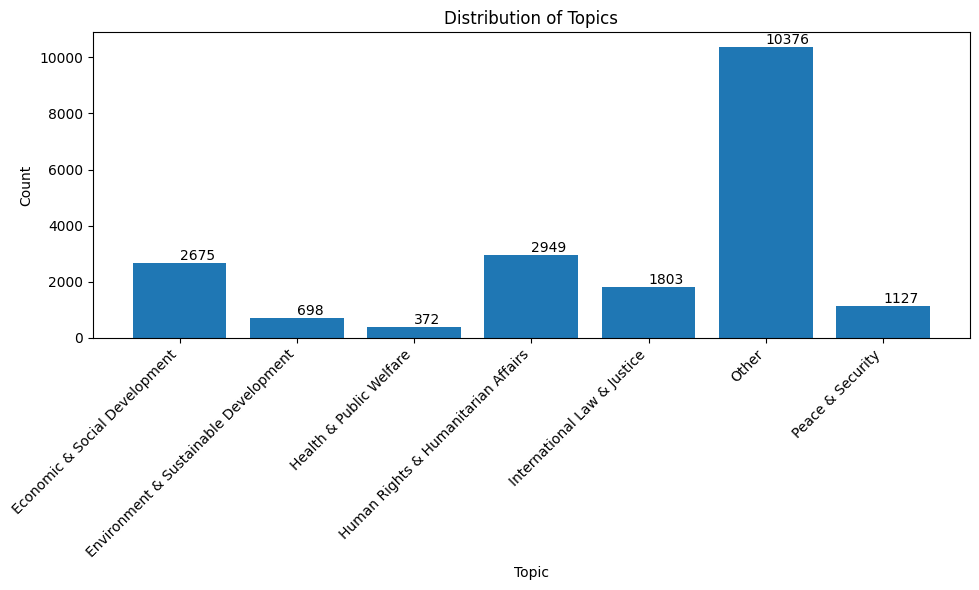

/tmp/ipython-input-16-423843124.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = parallelDatasetEnChi.groupby('topic').apply(lambda x: x.sample(n=min(len(x), 3), random_state=myStudentNumber)).reset_index(drop=True)


## Sampled Entries from Each Topic

,en,topic
0,"One delegate warned, however, that UNCTAD shou...",Economic & Social Development
1,18. Ms. Cravero (United Nations Development Pr...,Economic & Social Development
2,"PP-SPD-34: Hein de Haas, &quot; Remittances, M...",Economic & Social Development
3,(c) Further strengthening the scientific base ...,Environment & Sustainable Development
4,That any chlorofluorocarbon metered-dose inhal...,Environment & Sustainable Development
5,A Member of the Delegation of Malaysia to the ...,Environment & Sustainable Development
6,It included measures ensuring victims &apos; a...,Health & Public Welfare
7,There is widespread lack of awareness of healt...,Health & Public Welfare
8,The project &quot; Strategy on the management ...,Health & Public Welfare
9,Those people have been denied the right to ret...,Human Rights & Humanitarian Affairs


In [ ]:
"""
EDA
"""


# Get the value counts for the 'topic' column
topic_counts = parallelDatasetEnChi['topic'].value_counts()

# Sort the counts for better visualization
topic_counts = topic_counts.sort_index()

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(topic_counts.index, topic_counts.values)

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom') # ha='center' is default

plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Distribution of Topics')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()



# Sample 5 entries from each topic category
sampled_df = parallelDatasetEnChi.groupby('topic').apply(lambda x: x.sample(n=min(len(x), 3), random_state=myStudentNumber)).reset_index(drop=True)

# Display the sampled entries
display(Markdown("## Sampled Entries from Each Topic"))
display(sampled_df[['en', 'topic']])

In [ ]:
parallelDatasetEnChi.to_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/parallelDatasetEnChi.csv', index=False)
parallelDatasetEnEs.to_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/parallelDatasetEnEs.csv', index=False)
parallelDatasetEnFr.to_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/parallelDatasetEnFr.csv', index=False)

# II. Data Import

In [ ]:
parallelDatasetEnChi = pd.read_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/parallelDatasetEnChi.csv')
parallelDatasetEnEs = pd.read_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/parallelDatasetEnEs.csv')
parallelDatasetEnFr = pd.read_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/parallelDatasetEnFr.csv')


# III. Model Initialization

In [ ]:
# Monolingual (English)
all_mpnet_base_v2            = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
all_MiniLM_L6_v2             = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
all_roberta_large_v1         = SentenceTransformer("sentence-transformers/all-roberta-large-v1")
paraphrase_mpnet_base_v2     = SentenceTransformer("sentence-transformers/paraphrase-mpnet-base-v2")
paraphrase_MiniLM_L6_v2      = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")
bert_base_nli_mean_tokens    = SentenceTransformer("sentence-transformers/bert-base-nli-mean-tokens")

#  Multilingual
LaBSE = SentenceTransformer("sentence-transformers/LaBSE")
distiluse_base_multilingual_cased_v2 = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v2")
paraphrase_multilingual_MiniLM_L12_v2   = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
paraphrase_multilingual_mpnet_base_v2   = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
paraphrase_xlm_r_multilingual_v1        = SentenceTransformer("sentence-transformers/paraphrase-xlm-r-multilingual-v1")
xlm_r_distilroberta_base_paraphrase_v1  = SentenceTransformer("sentence-transformers/xlm-r-distilroberta-base-paraphrase-v1")
stsb_xlm_r_multilingual                 = SentenceTransformer("sentence-transformers/stsb-xlm-r-multilingual")
xlm_r_bert_base_nli_stsb_mean_tokens    = SentenceTransformer("sentence-transformers/xlm-r-bert-base-nli-stsb-mean-tokens")
xlm_r_100langs_bert_base_nli_stsb_mean_tokens = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")
xlm_r_100langs_bert_base_nli_mean_tokens = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-mean-tokens")
distilbert_multilingual_nli_stsb_quora_ranking = SentenceTransformer("sentence-transformers/distilbert-multilingual-nli-stsb-quora-ranking")
quora_distilbert_multilingual               = SentenceTransformer("sentence-transformers/quora-distilbert-multilingual")
xlm_r_large_en_ko_nli_ststb                 = SentenceTransformer("sentence-transformers/xlm-r-large-en-ko-nli-ststb")
xlm_r_base_en_ko_nli_ststb                  = SentenceTransformer("sentence-transformers/xlm-r-base-en-ko-nli-ststb")
clip_ViT_B_32_multilingual_v1               = SentenceTransformer("sentence-transformers/clip-ViT-B-32-multilingual-v1")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
models = {
    # Monolingual (English)
    "all_mpnet_base_v2": all_mpnet_base_v2,
    "all_MiniLM_L6_v2": all_MiniLM_L6_v2,
    "all_roberta_large_v1": all_roberta_large_v1,
    "paraphrase_mpnet_base_v2": paraphrase_mpnet_base_v2,
    "paraphrase_MiniLM_L6_v2": paraphrase_MiniLM_L6_v2,
    "bert_base_nli_mean_tokens": bert_base_nli_mean_tokens,

    # Multilingual / Cross-lingual
    "LaBSE": LaBSE,
    "distiluse_base_multilingual_cased_v2": distiluse_base_multilingual_cased_v2,
    "paraphrase_multilingual_MiniLM_L12_v2": paraphrase_multilingual_MiniLM_L12_v2,
    "paraphrase_multilingual_mpnet_base_v2": paraphrase_multilingual_mpnet_base_v2,
    "paraphrase_xlm_r_multilingual_v1": paraphrase_xlm_r_multilingual_v1,
    "xlm_r_distilroberta_base_paraphrase_v1": xlm_r_distilroberta_base_paraphrase_v1,
    "stsb_xlm_r_multilingual": stsb_xlm_r_multilingual,
    "xlm_r_bert_base_nli_stsb_mean_tokens": xlm_r_bert_base_nli_stsb_mean_tokens,
    "xlm_r_100langs_bert_base_nli_stsb_mean_tokens": xlm_r_100langs_bert_base_nli_stsb_mean_tokens,
    "xlm_r_100langs_bert_base_nli_mean_tokens": xlm_r_100langs_bert_base_nli_mean_tokens,
    "distilbert_multilingual_nli_stsb_quora_ranking": distilbert_multilingual_nli_stsb_quora_ranking,
    "quora_distilbert_multilingual": quora_distilbert_multilingual,
    "xlm_r_large_en_ko_nli_ststb": xlm_r_large_en_ko_nli_ststb,
    "xlm_r_base_en_ko_nli_ststb": xlm_r_base_en_ko_nli_ststb,
    "clip_ViT_B_32_multilingual_v1": clip_ViT_B_32_multilingual_v1
}


# IV. Utility Functions for Embedding Generation

In [ ]:
def getEmbeddings(
    df,
    model: torch.nn.Module,
    tokenizer=None,
    text_col: str = "en",
    batch_size: int = 32,
    device: torch.device = None,
    max_length: int = 512,
):


    if isinstance(model, SentenceTransformer):

        if device is not None:
            model.to(device)
            device_str = str(device)
        else:
            device_str = None

        sentences = df[text_col].astype(str).tolist()
        embs = model.encode(
            sentences,
            batch_size=batch_size,
            show_progress_bar=True,
            device=device_str,
            convert_to_numpy=True,
        )

        return embs


    if device is None:
        try:
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device("cpu")

    model.eval()


    texts = df[text_col].astype(str).tolist()
    all_embs = []


    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch_texts = texts[i : i + batch_size]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            token_embeddings = outputs.last_hidden_state


            mask = attention_mask.unsqueeze(-1)
            summed = (token_embeddings * mask).sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1e-9)
            emb = summed / counts


            emb = emb.float()
            emb = F.normalize(emb, p=2, dim=1)

        all_embs.append(emb.cpu().numpy())

    return np.vstack(all_embs)


In [ ]:
def pairwise_cosine(embA: np.ndarray, embB: np.ndarray) -> np.ndarray:
    return cosine_similarity(embA, embB)

In [ ]:
"""
The below function calculates cosine similarity for each sentence pairs and returns a dataframe with the following columns

"source_index"            :  query sentence index
"source_text"             :  query sentence
"candidate_index"         :  neighbor sentence index
"candidate_text"          :  neighbor sentence
"candidate_english_text"  :  neighbor sentence's true english pair
"cosine_similarity"       :  cosine similarity between the two sentences

"""

def generate_df_with_ess(df: pd.DataFrame,src_col: str,tgt_col: str,model,tokenizer=None,topk: int = 3,batch_size: int = 32,device=None,max_length: int = 512):
    src_texts = df[src_col].astype(str).tolist()
    tgt_texts = df[tgt_col].astype(str).tolist()

    emb_src = getEmbeddings(
        df, model, tokenizer,
        text_col=src_col,
        batch_size=batch_size,
        device=device,
        max_length=max_length,
    )
    emb_tgt = getEmbeddings(
        df, model, tokenizer,
        text_col=tgt_col,
        batch_size=batch_size,
        device=device,
        max_length=max_length,
    )

    sim_matrix = pairwise_cosine(emb_src, emb_tgt)


    records = []
    for i, query in enumerate(src_texts):
        scores = sim_matrix[i]
        topk_idxs = np.argsort(scores)[::-1][:topk]
        for rank, j in enumerate(topk_idxs, start=1):
            records.append({
                "source_index":          i,
                "source_text":    query,
                "candidate_index":       j,
                "candidate_text": tgt_texts[j],
                "candidate_english_text" : df[src_col].iloc[j],
                "labels" : df.iloc[i]["topic"],
                "candidate_topic": df.iloc[j]["topic"],
                "true_chinese":       df[tgt_col].iloc[i],
                "cosine_similarity":        float(scores[j]) ,
                "rank" : rank
            })


    df_out = pd.DataFrame(records)
    df_out.sort_values(["source_index","cosine_similarity"], ascending=[True,True], inplace=True)
    df_out.reset_index(drop=True, inplace=True)

    preds = sim_matrix.argmax(axis=1)
    acc = (preds == np.arange(len(preds))).mean()


    return df_out,sim_matrix


In [ ]:
def filter_by_languages_and_topic(df, src_lang, tgt_lang, topic_col='topic'):
    required_cols = [src_lang, tgt_lang, topic_col]
    # Ensure all required columns exist
    if not all(col in df.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df.columns]
        raise ValueError(f"DataFrame is missing required columns: {missing}")

    return df[required_cols]

# V. The Toolkit

## Level 1
### General Overview

In [ ]:
"""
General overview
gives random good and bad examples and
a histogram of similarity score distribution.

Purpose:
- Quick sanity check: Spot-check a handful of successes and failures to ensure your data pipeline and metrics make sense.
- High-level health: The histogram immediately shows the overall score spread, central tendency, and any surprising outliers.
- Threshold intuition: By seeing where most scores fall, you can choose similarity cutoffs that retain true matches while filtering noise.
- Data quality guard: Randomly sampling good/bad cases often exposes mislabels, formatting issues, or edge-case quirks early on.

"""
def general_overview(df, k: int = 5,visual_inspection=False):
    correct   = df[df['source_index'] == df['candidate_index']].sample(k) # , random_state=myStudentNumber
    incorrect = df[df['source_index'] != df['candidate_index']].sample(k) # , random_state=myStudentNumber


    if visual_inspection==True:
      print("\n### Some Good Matches")
      display(Markdown(tabulate(correct, headers='keys', tablefmt='github', showindex=False)))

      print("\n### Some Bad Matches")
      display(Markdown(tabulate(incorrect, headers='keys', tablefmt='github', showindex=False)))

    fig, ax = plt.subplots()
    ax.hist(df['cosine_similarity'], bins=20)
    ax.set_title('Similarity Score Distribution')
    ax.set_xlabel('Cosine similarity')
    ax.set_ylabel('Count')


    return {
        'figure': fig,
        'axes': ax
    }


In [ ]:
"""
True vs Random Off‐Diagonal Comparison

compare the similarity scores of true translation pairs against an equal‐sized sample
of off‐diagonal (random) pairs to establish a simple “signal‐to‐noise” baseline.

Purpose:
    - Signal-to-noise check: Measures how much real translations stand out from random sentence pairs.
    - Threshold guidance: Helps pick a similarity cutoff that keeps most true matches while discarding noise.
    - Model validation: Confirms the model is learning genuine cross-lingual alignment, not just arbitrary embeddings.
    - Progress tracking: Quantifies improvements over time—a wider gap means better separation.

"""
def true_vs_random_off_diagonal_analysis(sim_matrix):
    true_sims = np.diag(sim_matrix)
    M = sim_matrix.shape[0]
    mask = ~np.eye(M, dtype=bool)
    off_diag = sim_matrix[mask]

    rng = np.random.RandomState(myStudentNumber)
    random_sims = rng.choice(off_diag, size=true_sims.shape[0], replace=False)

    return true_sims, random_sims



def stats_true_vs_random_off_diagonl(true_sims, random_sims):
    stats = {
        "true_mean":        true_sims.mean(),
        "true_std":         true_sims.std(),
        "random_mean":      random_sims.mean(),
        "random_std":       random_sims.std(),
        "ks_p_value":       ks_2samp(true_sims, random_sims).pvalue
    }

    df_stats = pd.DataFrame(list(stats.items()), columns=["metric", "value"])
    display(Markdown(tabulate(df_stats, headers=["Statistic","Value"], tablefmt='github', showindex=False)))
    return df_stats



def plot_true_vs_random_off_diagonal(true_sims, random_sims):
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(random_sims, bins=50, alpha=0.5, label='Random pairs')
    ax.hist(true_sims,   bins=50, alpha=0.5, label='True translations')
    ax.set_xlabel('Cosine similarity')
    ax.set_ylabel('Frequency')
    ax.set_title('True vs. Random Pair Similarity')
    ax.legend()
    return fig, ax




In [ ]:
# Keys for the unified output schema
METRICS_KEY = "metrics"
PLOTS_KEY   = "plots"
META_KEY    = "meta"


def true_vs_random_off_diagonal_analysis(sim_matrix, random_seed=None):
    """
    Extract diagonal (true) similarities and a matched random sample.
    """
    true_sims = np.diag(sim_matrix)
    M = sim_matrix.shape[0]
    mask = ~np.eye(M, dtype=bool)
    off_diag = sim_matrix[mask]

    rng = np.random.RandomState(random_seed)
    random_sims = rng.choice(off_diag, size=true_sims.shape[0], replace=False)
    return true_sims, random_sims


def compute_sn_metrics(true_sims, random_sims):
    """
    Compute summary statistics for signal-to-noise analysis.
    """
    metrics = {
        "mean_true":        true_sims.mean(),
        "std_true":         true_sims.std(),
        "mean_random":      random_sims.mean(),
        "std_random":       random_sims.std(),
        "snr":              (true_sims.mean() - random_sims.mean()) / random_sims.std(),
        "ks_p_value":       ks_2samp(true_sims, random_sims).pvalue
    }
    return metrics


def plot_distribution(df):
    """
    Plot histogram of all cosine similarities.
    """
    fig, ax = plt.subplots()
    ax.hist(df['cosine_similarity'], bins=20)
    ax.set_title('Similarity Score Distribution')
    ax.set_xlabel('Cosine similarity')
    ax.set_ylabel('Count')
    return fig, ax


def plot_true_vs_random_overlay(true_sims, random_sims, figsize=(6,4)):
    """
    Plot overlay histogram of true vs. random similarities.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(random_sims, bins=50, alpha=0.5, label='Random pairs')
    ax.hist(true_sims,   bins=50, alpha=0.5, label='True translations')
    ax.set_xlabel('Cosine similarity')
    ax.set_ylabel('Frequency')
    ax.set_title('True vs. Random Pair Similarity')
    ax.legend()
    return fig, ax


def evaluate_signal_to_noise(df_with_sims, sim_matrix, random_seed=None):
    """
    Unified Level 0 evaluation: returns metrics, two plots, and metadata.
    """
    # 1. Split true and random samples
    true_sims, random_sims = true_vs_random_off_diagonal_analysis(
        sim_matrix, random_seed=random_seed
    )

    # 2. Compute metrics
    metrics = compute_sn_metrics(true_sims, random_sims)

    # 3. Generate plots
    fig_dist, ax_dist       = plot_distribution(df_with_sims)
    fig_overlay, ax_overlay = plot_true_vs_random_overlay(true_sims, random_sims)

    # 4. Metadata
    meta = {"n_pairs": len(true_sims)}

    # 5. Return unified dict
    return {
        METRICS_KEY: metrics,
        PLOTS_KEY: {
            "dist_chart": fig_dist,
            "rand_chart": fig_overlay
        },
        META_KEY: meta
    }

def level0(df, src_lang, tgt_lang, model, tokenizer=None, random_seed=None, **gen_kwargs):
    """
    Wrapper that runs the full Level 0 pipeline:
      1) generate sim DataFrame + matrix
      2) evaluate signal‐to‐noise
    """
    df_sims, sim_matrix = generate_df_with_ess(
        df, src_lang, tgt_lang, model, tokenizer, **gen_kwargs
    )
    return evaluate_signal_to_noise(df_sims, sim_matrix, random_seed)

# level0(parallelDatasetEnChi,"en","zh",LaBSE,LaBSE)

##  level 2
### Retrival Analysis

In [ ]:
"""

Retrieval Metrics and plots

This function answers the question
If I take my model’s top k most-similar English sentences for each other language query, how often is the correct translation among them?”


Purpose:
    - Recall@k                              : “For what fraction of queries did the true translation appear in the top k?”
    - Precision@k                           : “Out of all the k×N predictions, what fraction were actually correct?”
    - Mean Reciprocal Rank (MRR)            : “On average, how early does the correct translation appear? (1 divided by its rank, averaged across all queries; 1.0 is perfect.)”

    - Histogram of reciprocal ranks         :  To see the distribution of where correct answers land.
    - Cumulative Match Characteristic curve :  To show, for each rank threshold k, the fraction of queries whose correct translation is within the top k.
"""
# Schema keys for unified output
METRICS_KEY = "metrics"
PLOTS_KEY   = "plots"
META_KEY    = "meta"


def evaluate_retrieval_metrics_and_plot(df, k = 5, plot_hist = True, plot_cmc = True):

    score_matrix = (
        df
        .pivot(index='source_index', columns='candidate_index', values='cosine_similarity')
        .fillna(0)
    )
    query_ids = score_matrix.index.to_numpy()


    all_labels = np.unique(query_ids)
    score_matrix = score_matrix.reindex(columns=all_labels, fill_value=0)
    y_score = score_matrix.to_numpy()


    labels = score_matrix.columns.to_numpy()
    label_to_idx = {lab: i for i, lab in enumerate(labels)}


    ranks = []
    recips = []

    for i, q in enumerate(query_ids):
        row = y_score[i]
        true_col = label_to_idx[q]

        rank = int((row > row[true_col]).sum() + 1)
        ranks.append(rank)
        recips.append(1.0 / rank)


    recall_at_k = top_k_accuracy_score(
        y_true=query_ids,
        y_score=y_score,
        k=k,
        labels=all_labels
    )
    precision_at_k = recall_at_k / k
    mrr = float(np.mean(recips))

    metrics = {
        'recall@k': float(recall_at_k),
        'precision@k': float(precision_at_k),
        'mean reciprocal rank': float(mrr)
    }

    # if plot_hist:
    #     fig_rr, ax_rr = plt.subplots()
    #     ax_rr.hist(recips, bins=10)
    #     ax_rr.set_xlabel('Reciprocal Rank')
    #     ax_rr.set_ylabel('Frequency')
    #     ax_rr.set_title('Histogram of Reciprocal Ranks')



    if plot_cmc:
        worst = max(ranks)
        max_k = 10
        ks = list(range(1, max_k + 1))
        total = len(ranks)
        cmc_vals = [sum(1 for r in ranks if r <= kk)/total for kk in ks]

        fig_cmc, ax_cmc=plt.subplots()
        ax_cmc.plot(ks, cmc_vals, marker='o')
        ax_cmc.set_xlabel('Rank threshold k')
        ax_cmc.set_ylabel('Fraction of queries with rank ≤ k')
        ax_cmc.set_title('CMC Curve')
        ax_cmc.set_xticks(ks if len(ks)<=20 else np.linspace(1, max_k, 20, dtype=int))
        ax_cmc.set_ylim(0.8, 1.05)


    return {
        METRICS_KEY: metrics,
        PLOTS_KEY: {
            "cmc_curve":            fig_cmc,
            # "reciprocal_rank_hist": fig_rr
        },
        META_KEY: {
            "k":       k,
            "cmc_max": max_k
        }
    }

In [ ]:
def level1(
    df: pd.DataFrame,
    src_lang: str,
    tgt_lang: str,
    model,
    tokenizer=None,
    k: int = 5,
    plot_hist: bool = True,
    plot_cmc: bool = True,
    **gen_kwargs
) -> dict:

    # 1) Generate the scored DataFrame and similarity matrix
    df_sims, _ = generate_df_with_ess(
        df, src_lang, tgt_lang, model, tokenizer, **gen_kwargs
    )

    # 2) Delegate to your evaluation function
    return evaluate_retrieval_metrics_and_plot(
        df_sims,
        k=k,
        plot_hist=plot_hist,
        plot_cmc=plot_cmc
    )

# level1(parallelDatasetEnChi,"en","zh",DistilUSE,DistilUSE)


## Level 3
### Topic level Analysis and Visualization

In [ ]:
# Schema keys for unified output
METRICS_KEY = "metrics"
PLOTS_KEY   = "plots"
META_KEY    = "meta"

"""
Todo : Cosine Similarity by topic, How?
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap

def get_embeddings_for_topic_based_analysis(
    df,
    src_col= 'en',
    tgt_col= 'zh',
    model=None,
):
    """
    Melt wide df into one row per sentence with a 'language' column, then
    compute embeddings via a multilingual SentenceTransformer.

    Returns:
      df_long: DataFrame(columns=['sentence', topic_col, 'language'])
      embeddings: numpy array shape (len(df_long), embedding_dim)
    """
    frames = []
    for col, lang in [(src_col, src_col), (tgt_col, tgt_col)]:
        tmp = df[[col, "topic"]].rename(columns={col: 'sentence'})
        tmp['language'] = lang
        frames.append(tmp)
    df_long = pd.concat(frames, ignore_index=True)


    embeddings = model.encode(df_long['sentence'].tolist(),
                              convert_to_numpy=True)
    return df_long, embeddings


# def plot_umap_per_topic_and_language(
#     embeddings: np.ndarray,
#     df_long: pd.DataFrame,
#     topic_col: str = 'topic',
#     language_col: str = 'language',
#     random_state: int = 42
# ):
#     """
#     Run UMAP (cosine metric) on embeddings and plot 2D scatter:
#     - color by topic (via a colorbar)
#     - triangle marker for 'en', square for 'zh'
#     """
#     # 1) project
#     reducer = umap.UMAP(metric='cosine')
#     umap_2d = reducer.fit_transform(embeddings)

#     # 2) assemble plot dataframe
#     df = df_long.copy()
#     df['x'], df['y'] = umap_2d[:,0], umap_2d[:,1]
#     topics = list(df[topic_col].unique())
#     topic_idx = {t:i for i,t in enumerate(topics)}
#     df['topic_idx'] = df[topic_col].map(topic_idx)

#     # prepare a discrete colormap
#     cmap = plt.get_cmap('tab10')
#     colors = [cmap(i % cmap.N) for i in range(len(topics))]
#     topic2color = dict(zip(topics, colors))

#     # 3) plot
#     fig, ax = plt.subplots(figsize=(12, 8))
#     markers = {'en':'*', 'zh':'d'}
#     for lang, m in markers.items():
#         for t in topics:
#             sub = df[(df[language_col]==lang) & (df[topic_col]==t)]
#             ax.scatter(
#                 sub['x'], sub['y'],
#                 color=topic2color[t],
#                 marker=m,
#                 s=40,
#                 edgecolors='w', linewidths=0.3,
#                 alpha=0.8
#             )

#     ax.set_xlabel('UMAP 1')
#     ax.set_ylabel('UMAP 2')
#     ax.set_title('UMAP Projection: Topics (color) & Languages (shape)')

#     # 4) topic legend (colored patches)
#     topic_handles = [Patch(color=topic2color[t], label=t) for t in topics]
#     leg1 = ax.legend(
#         handles=topic_handles,
#         title='Topic',
#         bbox_to_anchor=(1.02, 1), loc='upper left',
#         frameon=False, fontsize='small'
#     )
#     ax.add_artist(leg1)

#     # 5) language legend (marker shapes)
#     lang_handles = [
#         Line2D([0], [0], marker=markers[l], color='lightgray',
#                markeredgecolor='k', markersize=8, linestyle='', label=('English' if l=='en' else 'Chinese'))
#         for l in markers
#     ]
#     ax.legend(
#         handles=lang_handles,
#         title='Language',
#         bbox_to_anchor=(1.02, 0.6), loc='upper left',
#         frameon=False, fontsize='small'
#     )

#     plt.tight_layout()
#     plots = {"umap_topics_lang": fig }

#     return plots
# # df_long, embeds = get_embeddings_for_topic_based_analysis(parallelDatasetEnChi)
# # a = plot_umap_per_topic_and_language(embeds, df_long)
# # print(type(a))


import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_umap_per_language(
    embeddings: np.ndarray,
    df_long: pd.DataFrame,
    src_lang: str,
    tgt_lang: str,
    topic_col: str = 'topic',
    language_col: str = 'language',
    random_state: int = 42
):
    """
    Run UMAP (cosine metric) on embeddings and generate one plot per language:
      - color by topic
      - English: '*' marker
      - Chinese: 'd' marker
    Returns a dict of {language: figure}.
    """
    # 1) project
    reducer = umap.UMAP(metric='cosine', random_state=random_state)
    umap_2d = reducer.fit_transform(embeddings)

    # 2) assemble plot dataframe
    df = df_long.copy()
    df['x'], df['y'] = umap_2d[:,0], umap_2d[:,1]
    topics = sorted(df[topic_col].unique())
    topic2idx = {t:i for i,t in enumerate(topics)}

    # discrete colormap
    cmap = plt.get_cmap('tab10')
    topic2color = {t: cmap(i % cmap.N) for i,t in enumerate(topics)}

    # 3) for each language, build a separate figure
    markers = {src_lang:'*', tgt_lang:'d'}
    figs = {}

    for lang, marker in markers.items():
        fig, ax = plt.subplots(figsize=(8,6))
        sub_df = df[df[language_col] == lang]

        for topic in topics:
            sub_t = sub_df[sub_df[topic_col] == topic]
            ax.scatter(
                sub_t['x'],
                sub_t['y'],
                c=[topic2color[topic]],
                marker=marker,
                s=50,
                edgecolors='w',
                linewidths=0.4,
                alpha=0.8,
                label=topic  # for building legend
            )

        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.set_title(f"UMAP Projection ― { lang.upper() }")

        # legend: colored patches for topics
        handles = [Patch(color=topic2color[t], label=t) for t in topics]
        ax.legend(
            handles=handles,
            title='Topic',
            bbox_to_anchor=(1.02, 1),
            loc='upper left',
            frameon=False,
            fontsize='small'
        )

        plt.tight_layout()
        figs[lang] = fig

    return figs
# df_long, embeds = get_embeddings_for_topic_based_analysis(parallelDatasetEnChi)
# a = plot_umap_per_topic_and_language(embeds, df_long)
# print(type(a))

In [ ]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_umap_by_language_and_length(
    embeddings: np.ndarray,
    df_long: pd.DataFrame,
    src_lang: str, # Add src_lang
    tgt_lang: str, # Add tgt_lang
    sentence_col: str = 'sentence',
    language_col: str = 'language',
    random_state: int = 42,
    length_clip: int = 100
):
    """
    Run UMAP (cosine metric) on embeddings and plot 2D scatter:
      - shape by language (src_lang vs tgt_lang)
      - color gradient by sentence length (chars), clipped to [0, length_clip]
    """

    # 1) UMAP projection
    reducer = umap.UMAP(metric='cosine')
    umap_2d = reducer.fit_transform(embeddings)

    # 2) Prepare DataFrame
    df = df_long.copy()
    df['x'], df['y'] = umap_2d[:, 0], umap_2d[:, 1]

    # Compute length (chars) and clip to [0, length_clip]
    df['length'] = df[sentence_col].str.len()
    df['length_clipped'] = df['length'].clip(upper=length_clip)

    # 3) Set up colormap and normalization
    cmap = plt.get_cmap('viridis')
    norm = Normalize(vmin=0, vmax=length_clip)

    # 4) Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    # Use src_lang and tgt_lang for markers
    markers = {src_lang: '*', tgt_lang: 'd'}  # star for source, diamond for target

    for lang, marker in markers.items():
        sub = df[df[language_col] == lang]
        ax.scatter(
            sub['x'], sub['y'],
            c=sub['length_clipped'],
            cmap=cmap,
            norm=norm,
            marker=marker,
            s=50,
            edgecolors='w',
            linewidths=0.4,
            alpha=0.8,
            label=(src_lang.upper() if lang == src_lang else tgt_lang.upper()) # Use src_lang and tgt_lang in label
        )

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP Projection: Language (shape) & Sentence Length (color)')

    # 5) Colorbar
    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label(f'Sentence Length (chars, clipped at {length_clip})')

    # 6) Legend for languages
    leg = ax.legend(title='Language', frameon=False, fontsize='small')
    ax.add_artist(leg)

    plt.tight_layout()
    plt.tight_layout()
    plots = {"umap_sent_len": fig }

    return plots

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from tqdm import tqdm


"""
Purpose:
how often the top-1 retrieved Chinese sentence shares the same topic as the English query.


Precision in this case: “Of all the Chinese sentences the model picked as closest, what fraction actually share the same topic?”

Recall in this case: “Of all the Chinese sentences that truly share the topic, what fraction did the model pick when they were the best match?”

"""

def retrieval_based_topic_confusion_matrix(
    df,
    model,
    batch_size=32,
    src_lang = 'en',
    tgt_lang = 'zh',
    device=None
):
    """
    Computes and plots topic-wise confusion matrix for parallel translations

    Args:
        df: DataFrame with columns: 'eng sentences', 'chinese sentences', 'topic'
        model_name: Multilingual embedding model
        batch_size: Batch size for embedding computation
        device: Torch device (e.g., 'cuda' or 'cpu')
    """
    # 1. Validate input columns
    required_cols = {'en', 'zh', 'topic'}
    assert required_cols.issubset(df.columns), "Missing required columns"

    # # 2. Load model
    # model = SentenceTransformer(model_name)
    # if device:
    #     model = model.to(device)
    device_str = str(device) if device else None

    # 3. Compute embeddings
     # 1) Compute embeddings
    eng_emb = getEmbeddings(df, model, model, src_lang, batch_size=batch_size, device=device)
    chn_emb = getEmbeddings(df, model, model, tgt_lang, batch_size=batch_size, device=device)

    # 2) Similarity matrix
    sim_matrix = pairwise_cosine(eng_emb, chn_emb)

    # 3) True & predicted
    topics       = df['topic'].astype(str).tolist()
    unique_topics = sorted(set(topics))
    y_true, y_pred = [], []
    for i in range(len(df)):
        pred_i = np.argmax(sim_matrix[i])
        y_true.append(topics[i])
        y_pred.append(topics[pred_i])

    # 4) Confusion matrices
    cm_recall    = confusion_matrix(y_true, y_pred, labels=unique_topics, normalize='true')
    cm_precision = confusion_matrix(y_true, y_pred, labels=unique_topics, normalize='pred')

    # 5) Extract flat metrics
    metrics = {}
    for idx, t in enumerate(unique_topics):
        metrics[f"recall_{t}"]    = float(cm_recall[idx, idx])
        metrics[f"precision_{t}"] = float(cm_precision[idx, idx])

    # 6) Plot recall‐heatmap
    fig_recall, ax_recall = plt.subplots(figsize=(6,6))
    sns.heatmap(
        cm_recall, annot=True, fmt=".2f", cmap="Blues",
        xticklabels=unique_topics, yticklabels=unique_topics,
        ax=ax_recall
    )
    ax_recall.set_xlabel("Predicted Topic")
    ax_recall.set_ylabel("True Topic")
    ax_recall.set_title("Topic Confusion (Recall)")

    # 7) Plot precision‐heatmap
    # fig_prec, ax_prec = plt.subplots(figsize=(6,6))
    # sns.heatmap(
    #     cm_precision, annot=True, fmt=".2f", cmap="Reds",
    #     xticklabels=unique_topics, yticklabels=unique_topics,
    #     ax=ax_prec
    # )
    # ax_prec.set_xlabel("Predicted Topic")
    # ax_prec.set_ylabel("True Topic")
    # ax_prec.set_title("Topic Confusion (Precision)")

    return {
        METRICS_KEY: metrics,
        PLOTS_KEY: {
            "confusion_recall":    fig_recall
        },
        META_KEY: {
            "topics": unique_topics
        }
    }


In [ ]:
def plot_topic_avg_cosine_similarity_matrix(
    df,
    model,
    batch_size=32,
    src_lang='en',
    tgt_lang='zh',
    device=None
) -> dict:
    """
    Computes and plots topic-wise average cosine similarity matrix

    Returns a dict with:
      {
        METRICS_KEY: {},
        PLOTS_KEY: {"topic_avg_cosine": <Figure>},
        META_KEY: {"topics": unique_topics}
      }

    Args:
        df: DataFrame with columns: src_lang, tgt_lang, 'topic'
        model: Pre-loaded embedding model
        batch_size: Batch size for embedding computation
        device: Torch device (e.g., 'cuda' or 'cpu')
    """
    # Validate input columns
    required_cols = {src_lang, tgt_lang, 'topic'}
    missing = required_cols - set(df.columns)
    assert not missing, f"Missing columns: {missing}"

    # Compute embeddings
    eng_emb = getEmbeddings(df, model, text_col=src_lang, batch_size=batch_size, device=device)
    chn_emb = getEmbeddings(df, model, text_col=tgt_lang, batch_size=batch_size, device=device)

    # Prepare topics and indices
    topics = df['topic'].astype(str).values
    unique_topics = sorted(set(topics))
    topic_indices = {t: np.where(topics == t)[0] for t in unique_topics}

    # Compute average similarity matrix
    n = len(unique_topics)
    sim_matrix = np.zeros((n, n))
    for i, ti in enumerate(unique_topics):
        for j, tj in enumerate(unique_topics):
            sims = pairwise_cosine(
                eng_emb[topic_indices[ti]],
                chn_emb[topic_indices[tj]]
            )
            sim_matrix[i, j] = float(np.mean(sims))

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        sim_matrix,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        xticklabels=unique_topics,
        yticklabels=unique_topics,
        cbar_kws={'label': 'Average Cosine Similarity'}
    )
    ax.set_title("Topic-wise Average Cosine Similarity", pad=20, fontsize=16)
    ax.set_xlabel(f"{tgt_lang.upper()} Topics", labelpad=15)
    ax.set_ylabel(f"{src_lang.upper()} Topics", labelpad=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    return {
        METRICS_KEY: {},
        PLOTS_KEY: {"topic_avg_cosine": fig},
        META_KEY: {"topics": unique_topics}
    }


In [ ]:
def level2(
    df: pd.DataFrame,
    src_lang: str,
    tgt_lang: str,
    model,
    tokenizer=None,
    random_seed=None,
    **gen_kwargs
) -> dict:
    """
    High‑level Topic‑Level Insight.
    Calls your two plotting helpers and always returns:
      {
        METRICS_KEY: {...},
        PLOTS_KEY: {
          "umap_topics_lang1": <Figure>,
          "umap_topics_lang2": <Figure>,
          "umap_sent_len":      <Figure>,
          "topic_confusion_recall": <Figure>
        },
        META_KEY: {}
      }
    """
    # 1) Get the long‑form DataFrame + embeddings
    df_long, embeds = get_embeddings_for_topic_based_analysis(
        df, src_lang, tgt_lang, model, **gen_kwargs
    )

    # 2) Call your two plot‑builders
    #    now returns {'en': fig_en, 'zh': fig_zh}
    out_topics = plot_umap_per_language(embeds, df_long,src_lang,tgt_lang)

    #    returns either a Figure or dict with key "umap_sent_len"
    out_len = plot_umap_by_language_and_length(embeds, df_long,src_lang,tgt_lang)

    # 3) Extract the two topic×lang figures
    try:
        fig1 = out_topics[src_lang]
        fig2 = out_topics[tgt_lang]
    except Exception:
        raise ValueError(
            "plot_umap_per_language must return a dict with keys "
            f"'{src_lang}' and '{tgt_lang}'"
        )

    # 4) Extract the Sent‑Len figure
    if isinstance(out_len, plt.Figure):
        fig_len = out_len
    elif isinstance(out_len, dict):
        fig_len = out_len.get("umap_sent_len", out_len.get("figure"))
    else:
        raise ValueError("plot_umap_by_language_and_length returned unexpected type")

    # 5) Compute confusion metrics
    # conf = retrieval_based_topic_confusion_matrix(
    #     df,
    #     model,
    #     batch_size=gen_kwargs.get("batch_size", 32),
    #     src_lang=src_lang,
    #     tgt_lang=tgt_lang,
    #     device=gen_kwargs.get("device", None)
    # )
    # 5) Compute topic‑average cosine similarity heatmap
    out_cos = plot_topic_avg_cosine_similarity_matrix(
        df,
        model,
        batch_size=gen_kwargs.get("batch_size", 32),
        src_lang=src_lang,
        tgt_lang=tgt_lang,
        device=gen_kwargs.get("device", None)
    )
    fig_cosine = out_cos[PLOTS_KEY]["topic_avg_cosine"]

    # 6) Return merged metrics + plots
    return {
        METRICS_KEY: out_cos.get(METRICS_KEY, {}),   # usually empty
        PLOTS_KEY: {
            "umap_topics_lang1":    fig1,
            "umap_topics_lang2":    fig2,
            "umap_sent_len":        fig_len,
            "topic_avg_cosine":     fig_cosine,
        },
        META_KEY: {}
    }

# print(level2(parallelDatasetEnChi, 'en', 'zh', LaBSE))

## Level **4**
### Error Analysis

In [ ]:
# Pre‐compile a regex that matches any CJK (Chinese/Japanese/Korean) character
CJK_RE = re.compile(r'[\u4E00-\u9FFF]')

def tokenize(text: str) -> list[str]:
    """
    If the text contains any CJK character, split it into characters.
    Otherwise, lowercase and split on whitespace for Latin‐based scripts.
    """
    if CJK_RE.search(text):
        # CJK: character‐level tokens
        return list(text)
    else:
        # Latin script: word‐level tokens
        return text.lower().split()

def jaccard(a: str, b: str) -> float:
    """
    Compute Jaccard similarity over tokens:
      |tokens(a) ∩ tokens(b)| / |tokens(a) ∪ tokens(b)|
    where tokens() is language‐aware (char‐level for CJK, word‐level otherwise).
    """
    ta = set(tokenize(a))
    tb = set(tokenize(b))
    if not ta and not tb:
        return 1.0
    return len(ta & tb) / len(ta | tb)

def levenshtein_ratio(a: str, b: str) -> float:
    """
    Compute normalized Levenshtein (edit‐distance) ratio:
      1 - (edit_distance / max(len(a), len(b)))
    via SequenceMatcher.
    """
    return SequenceMatcher(None, a, b).ratio()

def categorize_error_types(
    df: pd.DataFrame,
    true_col: str,
    pred_col: str,
    high_thresh: float = 0.5,
    low_thresh: float  = 0.2,
    method: str        = 'levenshtein'
) -> pd.DataFrame:
    """
    Annotate each row of a mis‐hit DataFrame with:
      - overlap_score (float)
      - error_type in {
          'lexical_confusion',
          'semantic_confusion',
          'topic_boundary_fuzziness'
        }

    Params:
    - df: DataFrame containing at least true_col and pred_col.
    - true_col: column name for the ground‐truth Chinese sentence.
    - pred_col: column name for the model’s predicted Chinese sentence.
    - high_thresh: score ≥ this → lexical_confusion
    - low_thresh:  score ≤ this → semantic_confusion
    - method: 'jaccard' or 'levenshtein'

    Returns:
    - df_out: copy of df with two new columns:
        - 'overlap_score'
        - 'error_type'
    """
    overlap_scores = []
    error_types    = []

    for true_txt, pred_txt in zip(df[true_col], df[pred_col]):
        # compute chosen overlap score
        if method == 'jaccard':
            score = jaccard(true_txt, pred_txt)
        elif method == 'levenshtein':
            score = levenshtein_ratio(true_txt, pred_txt)
        else:
            raise ValueError(f"Unknown method: {method!r}")

        # assign error type
        if score >= high_thresh:
            et = 'lexical_confusion'
        elif score <= low_thresh:
            et = 'semantic_confusion'
        else:
            et = 'topic_boundary_fuzziness'

        overlap_scores.append(score)
        error_types.append(et)

    # build output DataFrame
    df_out = df.copy()
    df_out['overlap_score'] = overlap_scores
    df_out['error_type']    = error_types

    return df_out


In [ ]:
# Schema keys for unified output
METRICS_KEY = "metrics"
PLOTS_KEY   = "plots"
META_KEY    = "meta"

def error_analysis(
    df: pd.DataFrame,
    model_name,
    src_col: str = 'en',
    tgt_col: str = 'zh',
    topk: int = 5,
    high_thresh: float = 0.3,
    low_thresh: float  = 0.1,
    overlap_method: str = 'jaccard'
) -> dict:
    """
    Performs retrieval‐based error analysis and returns:
      {
        METRICS_KEY: summary_dict,
        PLOTS_KEY: {
          'error_count_bar': <Figure>,
          'error_pct_bar':   <Figure>
        },
        META_KEY: {
          'topk': topk,
          'high_thresh': high_thresh,
          'low_thresh': low_thresh,
          'overlap_method': overlap_method
        }
      }
    """
    # 1) Embeddings & retrieval table
    # (assumes model_name is a SentenceTransformer instance)
    df_out, sim_matrix = generate_df_with_ess(
        df, src_col, tgt_col, model_name, topk=topk
    )

    # 2) Split near vs. far misses
    mis_hits    = df_out[df_out['rank'] != 1]
    near_misses = mis_hits[mis_hits['rank'].between(2, 3)]
    far_misses  = mis_hits[mis_hits['rank'] > 3]

    # 3) Tag errors
    near_tagged = categorize_error_types(
        near_misses, 'true_chinese', 'candidate_text',
        high_thresh, low_thresh, overlap_method
    )
    far_tagged  = categorize_error_types(
        far_misses, 'true_chinese', 'candidate_text',
        high_thresh, low_thresh, overlap_method
    )

    # 4) Aggregate counts & percentages
    counts = pd.DataFrame({
        'near_count': near_tagged['error_type'].value_counts(),
        'far_count':  far_tagged ['error_type'].value_counts()
    }).fillna(0).astype(int)
    pcts = pd.DataFrame({
        'near_pct': near_tagged['error_type'].value_counts(normalize=True) * 100,
        'far_pct':  far_tagged ['error_type'].value_counts(normalize=True) * 100
    }).fillna(0)
    summary = pd.concat([counts, pcts], axis=1)



 # 6) Plot 2: error counts with annotations
    fig_pct, ax_cnt = plt.subplots(figsize=(8, 5))
    # Plot the counts instead of percentages
    summary[['near_count', 'far_count']].plot(
        kind='bar', ax=ax_cnt, rot=30
    )
    ax_cnt.set_title('Error‑Type Counts: Near vs Far Misses')
    ax_cnt.set_ylabel('Count')

    # annotate each bar with its count
    for p in ax_cnt.patches:
        h = p.get_height()
        if h > 0:
            ax_cnt.text(
                p.get_x() + p.get_width()/2, h + 0.5,
                f"{int(h)}",           # show integer count
                ha='center', va='bottom',
                fontsize='small'
            )

    # 7) Return standardized dict
    return {
        METRICS_KEY: summary.to_dict(orient='index'),
        PLOTS_KEY: {
            'error_pct_bar':   fig_pct
        },
        META_KEY: {
            'topk': topk,
            'high_thresh': high_thresh,
            'low_thresh': low_thresh,
            'overlap_method': overlap_method
        }
    }

In [ ]:
def level3(
    df: pd.DataFrame,
    src_lang: str,
    tgt_lang: str,
    model,
    tokenizer=None,
    topk: int = 5,
    high_thresh: float = 0.3,
    low_thresh: float  = 0.2,
    overlap_method: str = 'jaccard',
    **gen_kwargs
) -> dict:
    """
    Wrapper for Level 3: Error‑Type Diagnostics.

    Calls your `error_analysis` function and returns its standardized output:
      {
        METRICS_KEY: {...},
        PLOTS_KEY: { 'error_count_bar': Figure, 'error_pct_bar': Figure },
        META_KEY: { 'topk':…, 'high_thresh':…, 'low_thresh':…, 'overlap_method':… }
      }
    """
    # Delegate to error_analysis, passing src/tgt column names and thresholds
    result = error_analysis(
        df,
        model,               # your SentenceTransformer instance
        src_col=src_lang,
        tgt_col=tgt_lang,
        topk=topk,
        high_thresh=high_thresh,
        low_thresh=low_thresh,
        overlap_method=overlap_method
    )
    return result

# VI.Render Output

In [ ]:
"""
Functions to get model info
"""



def hub_repo_id(st_model, fallback: str) -> str:
    #  common attributes on SentenceTransformer & underlying HF model
    for attr in ("model_name", "model_name_or_path", "name_or_path"):
        if hasattr(st_model, attr):
            val = getattr(st_model, attr)
            if val:                       # non-empty string
                return val
    #  fall back: add org prefix if user’s key lacks “/”
    return f"sentence-transformers/{fallback}" if "/" not in fallback else fallback


def model_info(st_model, fallback_name: str):
    """
    Return {arch, hidden_size, layers, vocab_size} for any Sentence-Transformer.
    Works whether the model was loaded from the Hub or from a local folder.
    """
    #  try the live config already inside the SentenceTransformer
    cfg = None
    try:
        cfg = st_model._first_module().auto_model.config
    except AttributeError:
        pass        # not all modules expose this; continue below if None

    #  if that failed, fall back to HF Hub using an ID guess
    if cfg is None:
        repo_id = getattr(st_model, "model_name_or_path", fallback_name)
        if "/" not in repo_id:            # user passed plain key like "LaBSE"
            repo_id = f"sentence-transformers/{repo_id}"
        cfg = AutoConfig.from_pretrained(repo_id)


    def pick(obj, *cands):
        for c in cands:
            if hasattr(obj, c):
                return getattr(obj, c)
        return "N/A"

    return OrderedDict([
        ("arch",        cfg.model_type),
        ("hidden_size", pick(cfg, "hidden_size", "d_model", "n_embd", "embed_dim")),
        ("layers",      pick(cfg, "num_hidden_layers", "num_layers", "n_layer")),
        ("vocab_size",  getattr(cfg, "vocab_size", "N/A")),
    ])

In [ ]:
"""
Helper functions to render the dashboard
"""


# Schema keys
METRICS_KEY = "metrics"
PLOTS_KEY   = "plots"

# 1) Replacement fig‑to‑thumb helper that hooks into our modal
def fig_to_base64_img(fig, thumb_width=140):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight")
    plt.close(fig)
    b64 = base64.b64encode(buf.getvalue()).decode("utf8")
    src = f"data:image/png;base64,{b64}"
    return (
        f'<img src="{src}" '
        f'width="{thumb_width}px" '
        f'style="cursor:pointer;" '
        f'onclick="openModal(\'{src}\')"/>'
    )

# 2) Metrics table helper (unchanged)
def metrics_to_html_table(metrics: dict) -> str:
    df_stats = pd.DataFrame(list(metrics.items()), columns=["Statistic", "Value"])
    html = df_stats.to_html(index=False, border=0).replace('\n', '')
    html = html.replace(
        '<table',
        '<table style="margin:0 auto; border-collapse:collapse; font-size:0.8em;"'
    ).replace(
        '<th>',
        '<th style="border:1px solid #ddd; padding:4px; text-align:center; font-size:0.8em;">'
    ).replace(
        '<td>',
        '<td style="border:1px solid #ddd; padding:4px; text-align:center; font-size:0.8em;">'
    )
    return html

In [ ]:
"""
The main function that renders the dashboard
"""
def render_dashboard(
    df: pd.DataFrame,
    src_lang: str,
    tgt_lang: str,
    models: dict,
    tokenizer=None,
    random_seed=None,
    **gen_kwargs
):
    # Suppress warnings
    warnings.filterwarnings('ignore')

    # Language code to full name mapping
    lang_names = {
        "en": "English",
        "fr": "French",
        "zh": "Chinese",
        "es": "Spanish"
    }

    # Lightbox assets
    lightbox = """
    <style>
      .modal {
        display: none;
        position: fixed;
        top: 0; left: 0; width: 100%; height: 100%;
        background: rgba(0,0,0,0.8);
        justify-content: center; align-items: center;
        z-index: 9999;
      }
      .modal img {
        max-width: 90%; max-height: 90%;
        box-shadow: 0 0 20px rgba(0,0,0,0.5);
      }
    </style>
    <script>
      function openModal(src) {
        const m = document.getElementById('imgModal');
        m.querySelector('img').src = src;
        m.style.display = 'flex';
      }
      function closeModal() {
        document.getElementById('imgModal').style.display = 'none';
      }
    </script>
    <div id="imgModal" class="modal" onclick="closeModal()">
      <img/>
    </div>
    """


    # 1) Run each level
    results = {}
    for name, model in models.items():
        print("Running: ",end="")
        print(name)
        results[name] = {
            'signal':    level0(df, src_lang, tgt_lang, model, tokenizer, random_seed, **gen_kwargs),
            'retrieval': level1(df, src_lang, tgt_lang, model, tokenizer, **gen_kwargs),
            'topic':     level2(df, src_lang, tgt_lang, model, tokenizer, random_seed),
            'error':     level3(df, src_lang, tgt_lang, model, tokenizer, **gen_kwargs)
        }

    # 2) Build blank DataFrame
    columns = [
        ('', 'Model'),('', 'Model Info'),
        ('Level 0 : Basic Overview','Dist Chart'),
        ('Level 0 : Basic Overview','Rand Chart'),
        ('Level 0 : Basic Overview','Basic Stats'),
        ('Level 1 : Retrieval','CMC Curve'),
        ('Level 1 : Retrieval','Retrieval Stats'),
        ('Level 2 : Topic‑Level','UMAP (Topics & Lang1)'),
        ('Level 2 : Topic‑Level','UMAP (Topics & Lang2)'),
        ('Level 2 : Topic‑Level','UMAP (Sent‑Len)'),
        ('Level 2 : Topic‑Level','Topic Avg Cosine'),
        ('Level 3 : Error‑Type','Error % Bar Chart'),
    ]
    mi_cols = pd.MultiIndex.from_tuples(columns)
    dashboard = pd.DataFrame(index=results.keys(), columns=mi_cols)

    # 3) Populate
    for name, dims in results.items():
        s, r, t, e = dims['signal'], dims['retrieval'], dims['topic'], dims['error']
        model_id = hub_repo_id(models[name], name)   # ← add this line
        dashboard.at[name, ('','Model')]      = name
        dashboard.at[name, ('', 'Model Info')] = model_info(models[name], name)

        # Level 0
        dashboard.at[name, ('Level 0 : Basic Overview','Dist Chart')] = s[PLOTS_KEY]['dist_chart']
        dashboard.at[name, ('Level 0 : Basic Overview','Rand Chart')] = s[PLOTS_KEY]['rand_chart']
        dashboard.at[name, ('Level 0 : Basic Overview','Basic Stats')] = s[METRICS_KEY]

        # Level 1
        dashboard.at[name, ('Level 1 : Retrieval','CMC Curve')]    = r[PLOTS_KEY]['cmc_curve']
        dashboard.at[name, ('Level 1 : Retrieval','Retrieval Stats')] = r[METRICS_KEY]

        # Level 2
        # assume `t` is the dict returned by level2(...)
        dashboard.at[name, ('Level 2 : Topic‑Level','UMAP (Topics & Lang1)')] = t[PLOTS_KEY]['umap_topics_lang1']
        dashboard.at[name, ('Level 2 : Topic‑Level','UMAP (Topics & Lang2)')] = t[PLOTS_KEY]['umap_topics_lang2']
        dashboard.at[name, ('Level 2 : Topic‑Level','UMAP (Sent‑Len)')]      = t[PLOTS_KEY]['umap_sent_len']
        dashboard.at[name, ('Level 2 : Topic‑Level','Topic Avg Cosine')]     = t[PLOTS_KEY]['topic_avg_cosine']


        # Level 3
        dashboard.at[name, ('Level 3 : Error‑Type','Error % Bar Chart')] = e[PLOTS_KEY]['error_pct_bar']

    # 4) Convert figs → clickable thumbnails
    chart_cols = [
        ('Level 0 : Basic Overview','Dist Chart'),
        ('Level 0 : Basic Overview','Rand Chart'),
        ('Level 1 : Retrieval','CMC Curve'),
        ('Level 2 : Topic‑Level','UMAP (Topics & Lang1)'),
         ('Level 2 : Topic‑Level','UMAP (Topics & Lang2)'),
        ('Level 2 : Topic‑Level','UMAP (Sent‑Len)'),
         ('Level 2 : Topic‑Level','Topic Avg Cosine'),
        ('Level 3 : Error‑Type','Error % Bar Chart'),
    ]
    for model_name in dashboard.index:


        for col in chart_cols:
            fig = dashboard.at[model_name, col]
            dashboard.at[model_name, col] = fig_to_base64_img(fig)

    # 5) Converting metrics to small tables
    stats_cols = [
        ('', 'Model Info'),
        ('Level 0 : Basic Overview','Basic Stats'),
        ('Level 1 : Retrieval','Retrieval Stats'),
    ]
    for model_name in dashboard.index:
        for col in stats_cols:
            dashboard.at[model_name, col] = metrics_to_html_table(
                dashboard.at[model_name, col]
            )

    # 6) Rendering the table
    core_html = dashboard.to_html(escape=False, index=False)
    core_html = core_html.replace(
        '<table', '<table style="border-collapse:collapse; width:100%;"'
    ).replace(
        '<th>', '<th style="border:1px solid #ddd; padding:6px; text-align:center;">'
    ).replace(
        '<td>', '<td style="border:1px solid #ddd; padding:6px; text-align:center;">'
    )

    # 7) Add H1 title and prepend the lightbox snippet
    title_html = f"<h1 style='text-align:center;'>Embedding similarity evaluation : {lang_names.get(src_lang, src_lang)}-{lang_names.get(tgt_lang, tgt_lang)}</h1>"
    full_html = lightbox + title_html + core_html
    return full_html

# VII. Testing Models

## The English-Chinese Dataset

In [ ]:
html_tbl = render_dashboard(
    parallelDatasetEnChi, "en", "zh",
    models= models,
        random_seed=42,
    topk=5,
    batch_size=64,
    device="cuda")

with open("English_Chinese_dashboard_report.html", "w", encoding="utf-8") as f:
    f.write(html_tbl)


source_path = "English_Chinese_dashboard_report.html"
destination_path = "/content/drive/MyDrive/Dissertation_NclxOw/English_Chinese_dashboard_report.html"


shutil.copyfile(source_path, destination_path)


print(f"Dashboard saved to {destination_path}")

Running: all_roberta_large_v1


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Running: LaBSE


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Dashboard saved to /content/drive/MyDrive/Dissertation_NclxOw/English_Chinese_dashboard_report.html


## English - Spanish Dataset

In [ ]:
# English - Spanish Dataset
html_tbl_es = render_dashboard(
    parallelDatasetEnEs, "en", "es",
    models= models,
    random_seed=42,
    topk=5,
    batch_size=64,
    device="cuda"
)

with open("English_Spanish_dashboard_report.html", "w", encoding="utf-8") as f:
    f.write(html_tbl_es)

source_path_es = "English_Spanish_dashboard_report.html"
destination_path_es = "/content/drive/MyDrive/Dissertation_NclxOw/English_Spanish_dashboard_report.html"

shutil.copyfile(source_path_es, destination_path_es)

print(f"English-Spanish Dashboard saved to {destination_path_es}")

Running: all_roberta_large_v1


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Running: LaBSE


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

English-Spanish Dashboard saved to /content/drive/MyDrive/Dissertation_NclxOw/English_Spanish_dashboard_report.html


## English - French Dataset

In [ ]:
# English - French Dataset
html_tbl_fr = render_dashboard(
    parallelDatasetEnFr, "en", "fr",
    models= models,
    random_seed=42,
    topk=5,
    batch_size=64,
    device="cuda"
)

with open("English_French_dashboard_report.html", "w", encoding="utf-8") as f:
    f.write(html_tbl_fr)

source_path_fr = "English_French_dashboard_report.html"
destination_path_fr = "/content/drive/MyDrive/Dissertation_NclxOw/English_French_dashboard_report.html"

shutil.copyfile(source_path_fr, destination_path_fr)

print(f"English-French Dashboard saved to {destination_path_fr}")

Running: all_roberta_large_v1


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Running: LaBSE


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

English-French Dashboard saved to /content/drive/MyDrive/Dissertation_NclxOw/English_French_dashboard_report.html
